In [3]:
import pandas as pd
import talib
from talib import abstract

# 读取数据，并解析 'timestamp' 列为日期时间格式
df = pd.read_csv("merged_kline_1year.csv", parse_dates=['timestamp'])

# 将列名 'vol' 重命名为 'volume'
df.rename(columns={'vol': 'volume'}, inplace=True)

# 创建空的 DataFrame 存储所有特征
features = pd.DataFrame(index=df.index)

# 获取 TA-Lib 所有支持的函数列表
all_functions = talib.get_functions()

failed_functions = []

for func_name in all_functions:
    try:
        # 使用 Abstract API 创建指标函数
        func = abstract.Function(func_name)
        # 计算指标，传入整个 DataFrame
        result = func(df)
        
        # 如果返回值是 DataFrame（例如 BBANDS 返回多个输出），分别存储
        if isinstance(result, pd.DataFrame):
            for col in result.columns:
                features[f"{func_name}_{col}"] = result[col]
        # 如果返回 Series，直接存储
        elif isinstance(result, pd.Series):
            features[func_name] = result
        # 如果返回元组，依次存储各个输出结果
        elif isinstance(result, tuple):
            for i, series in enumerate(result):
                if not isinstance(series, pd.Series):
                    series = pd.Series(series, index=df.index)
                features[f"{func_name}_{i}"] = series
        else:
            # 其他情况直接存储
            features[func_name] = result
    except Exception as e:
        failed_functions.append((func_name, str(e)))
        print(f"Function {func_name} failed: {e}")

# 合并原始数据和生成的特征
final_df = pd.concat([df, features], axis=1)
final_df.to_csv("merged_kline_features.csv", index=False)

print(f"生成特征完毕，共 {features.shape[1]} 个特征.")
if failed_functions:
    print("以下函数计算失败：")
    for func, error in failed_functions:
        print(f"{func}: {error}")


Function MAVP failed: input_arrays parameter missing required data key: periods


C:\Users\36679\AppData\Local\Temp\ipykernel_50896\1107246527.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features[func_name] = result
C:\Users\36679\AppData\Local\Temp\ipykernel_50896\1107246527.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features[func_name] = result
C:\Users\36679\AppData\Local\Temp\ipykernel_50896\1107246527.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at o

生成特征完毕，共 174 个特征.
以下函数计算失败：
MAVP: input_arrays parameter missing required data key: periods


In [5]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# 读取数据
df = pd.read_csv("merged_kline_features.csv", parse_dates=['timestamp'])
df.sort_values('timestamp', inplace=True)

# 构造目标变量：下一个时间点的相对价格变化（收益率）
# 使用收盘价 'close'
df['target'] = df['close'].shift(-1) / df['close'] - 1

# 删除最后一行（因为它没有未来值）
df = df.iloc[:-1]

# 筛选特征，排除原始字段和目标字段
# 假设我们使用所有数值型特征，排除 'timestamp' 和 'source_file'
exclude_cols = ['timestamp', 'source_file', 'target']
feature_cols = [col for col in df.columns if col not in exclude_cols and df[col].dtype in [np.float64, np.float32, np.int64, np.int32]]
print(f"使用特征数：{len(feature_cols)}")

# 填充缺失值，这里采用简单的均值填充
df[feature_cols] = df[feature_cols].fillna(method='ffill').fillna(method='bfill')

# 构造训练和测试数据（注意时间顺序，切分时应用时间序列划分策略）
# 例如：前80%作为训练，后20%作为测试
split_idx = int(len(df) * 0.8)
train_df = df.iloc[:split_idx]
test_df = df.iloc[split_idx:]

X_train = train_df[feature_cols]
y_train = train_df['target']
X_test = test_df[feature_cols]
y_test = test_df['target']

# 训练随机森林回归模型
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 预测并评估
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"测试集均方误差: {mse:.6f}")

# 查看部分预测结果
results = test_df[['timestamp', 'close', 'target']].copy()
results['predicted_target'] = y_pred
print(results.head())

使用特征数：179


C:\Users\36679\AppData\Local\Temp\ipykernel_50896\2061452550.py:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[feature_cols] = df[feature_cols].fillna(method='ffill').fillna(method='bfill')


测试集均方误差: 0.000002
                 timestamp    close    target  predicted_target
517142 2024-12-08 21:13:00  0.45974 -0.000348          0.000333
517143 2024-12-08 21:14:00  0.45958  0.000348          0.000441
517144 2024-12-08 21:15:00  0.45974  0.001153          0.000345
517145 2024-12-08 21:16:00  0.46027  0.000130          0.000161
517146 2024-12-08 21:17:00  0.46033  0.000999          0.000329


测试集均方误差 (MSE): 0.000002
测试集均方根误差 (RMSE): 0.001390
测试集决定系数 (R²): 0.046699

特征重要性:
                 feature  importance
13                   DIV    0.090204
174                 NATR    0.032513
75        STOCHRSI_fastk    0.025283
177                ADOSC    0.024652
4                 volume    0.024274
..                   ...         ...
133           CDLKICKING    0.000000
134   CDLKICKINGBYLENGTH    0.000000
144          CDLPIERCING    0.000000
140           CDLMATHOLD    0.000000
159  CDLXSIDEGAP3METHODS    0.000000

[179 rows x 2 columns]


C:\Users\36679\AppData\Local\Temp\ipykernel_50896\2954951276.py:29: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\36679\AppData\Local\Temp\ipykernel_50896\2954951276.py:29: UserWarning: Glyph 24449 (\N{CJK UNIFIED IDEOGRAPH-5F81}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\36679\AppData\Local\Temp\ipykernel_50896\2954951276.py:29: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\36679\AppData\Local\Temp\ipykernel_50896\2954951276.py:29: UserWarning: Glyph 35201 (\N{CJK UNIFIED IDEOGRAPH-8981}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\36679\AppData\Local\Temp\ipykernel_50896\2954951276.py:29: UserWarning: Glyph 24615 (\N{CJK UNIFIED IDEOGRAPH-6027}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\36679\Downloads\daima\COIN\coin\Lib\site-packages\IPython\core\pylabtools.py:170: User

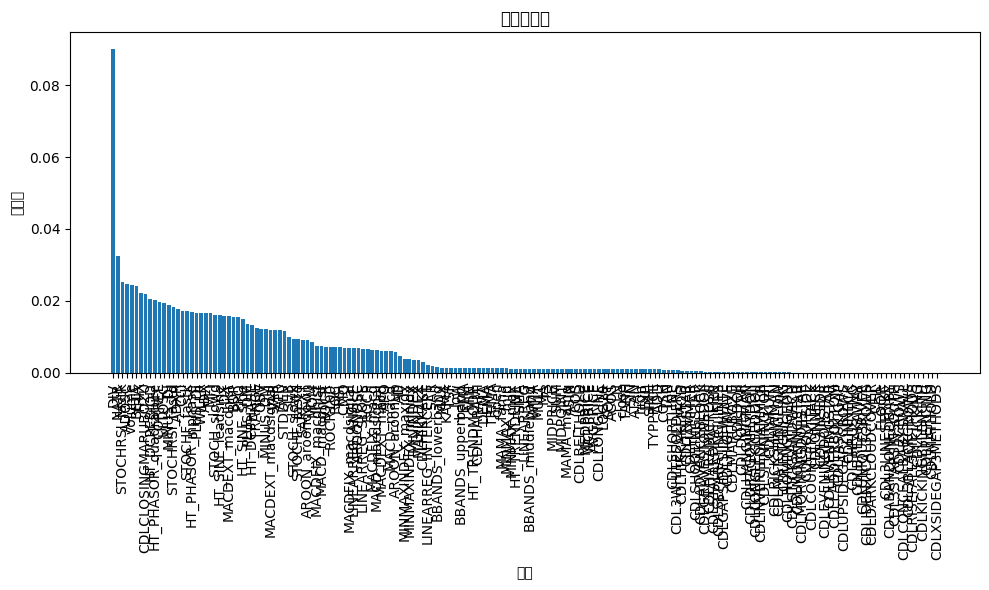

In [6]:
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# 计算更多评估指标
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"测试集均方误差 (MSE): {mse:.6f}")
print(f"测试集均方根误差 (RMSE): {rmse:.6f}")
print(f"测试集决定系数 (R²): {r2:.6f}")

# 获取并打印特征重要性
importances = model.feature_importances_
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': importances
}).sort_values(by='importance', ascending=False)

print("\n特征重要性:")
print(importance_df)

# 可视化特征重要性
plt.figure(figsize=(10, 6))
plt.bar(importance_df['feature'], importance_df['importance'])
plt.xlabel('特征')
plt.ylabel('重要性')
plt.title('特征重要性')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [7]:
# 计算测试集目标均值
target_mean = y_test.mean()

# 打印 RMSE 和目标均值的比较
print(f"测试集目标均值: {target_mean:.6f}")
print(f"测试集 RMSE: {rmse:.6f}")
print(f"RMSE 与目标均值的比例: {rmse / target_mean:.6f}")


测试集目标均值: -0.000006
测试集 RMSE: 0.001390
RMSE 与目标均值的比例: -246.876168
